In [1]:
# === SYSTEM-CHECK & IMPORTS ===
# Hier importieren wir die notwendigen Basis-Bibliotheken
import os, sys, json, time, hashlib, platform
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Wir geben die Versionen aus, um sicherzustellen, dass die Umgebung passt
print("Python:", sys.version)
print("OS:", platform.platform())
try:
    # TensorFlow checken, falls wir es später für GPU-Support brauchen
    import tensorflow as tf
    print("tensorflow:", tf.__version__, "| GPUs:", len(tf.config.list_physical_devices('GPU')))
except Exception as e:
    print("TF-Check:", e)

Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
tensorflow: 2.20.0 | GPUs: 0


In [2]:
# === KONFIGURATION LADEN ===
# Wir setzen das Root-Verzeichnis, damit unsere Imports funktionieren
ROOT = os.path.abspath("..")
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

# config.json wird geladen - das ist die zentrale Steuerdatei für alle Parameter
with open(os.path.join(ROOT, "config.json"), "r") as f:
    C = json.load(f)

# Hier entpacken wir die wichtigen Parameter in Variablen für leichten Zugriff
TICKER   = C["ticker"]       # Welches Asset? (z.B. AAPL)
START    = C["start"]        # Startdatum für Daten
END      = C["end"]          # Enddatum
INTERVAL = C["interval"]     # Zeitintervall (z.B. 1d)
HORIZON  = int(C["horizon"]) # Vorhersage-Horizont (z.B. 1 Tag in die Zukunft)
LOOKBACK = int(C["lookback"])# Wieviele Tage schauen wir zurück (z.B. 60)
BATCH    = int(C["batch"])   # Batch-Size fürs Training
EPOCHS   = int(C["epochs"])  # Anzahl Training-Epochen
SEED     = int(C.get("seed", 42)) # Seed für Reproduzierbarkeit

# Ergebnis-Ordner erstellen, falls nicht existent
RESULTS_DIR = Path(C.get("results_dir", "../results"))
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Daten-Ordner erstellen
os.makedirs("../data", exist_ok=True)
# Pfad für die rohe CSV-Datei definieren
RAW_CSV = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"

In [3]:
# === DATEN-DOWNLOAD & BEREINIGUNG ===
import yfinance as yf

# Daten von Yahoo Finance laden
df = yf.download(
    TICKER, start=START, end=END, interval=INTERVAL,
    auto_adjust=True, group_by="column", threads=False, progress=False
)

# Manchmal kommt ein MultiIndex zurück, den müssen wir flachklopfen
if isinstance(df.columns, pd.MultiIndex):
    top  = df.columns.get_level_values(0).str.lower()
    bot  = df.columns.get_level_values(1).str.lower()
    # Checken, auf welcher Ebene die Spaltennamen (open, close etc.) stehen
    if {"open","high","low","close","adj close","volume"} & set(bot):
        df.columns = df.columns.get_level_values(1)
    elif {"open","high","low","close","adj close","volume"} & set(top):
        df.columns = df.columns.get_level_values(0)
    else:
        if len(set(top)) == 1:
            df.columns = df.columns.get_level_values(1)
        else:
            raise RuntimeError(f"Unbekannte MultiIndex-Struktur: {list(df.columns)})")

# Spaltennamen vereinheitlichen: kleinschreiben, Leerzeichen weg
df = df.rename(columns=lambda c: str(c).strip().lower().replace(" ",""))

# Falls wir 'adjclose' haben, nutzen wir das als 'close'
if "close" not in df.columns and "adjclose" in df.columns:
    df["close"] = df["adjclose"]

# Index sauber als Datetime formatieren
df.index = pd.to_datetime(df.index, errors="coerce")

# Duplikate im Index zählen (wichtig für Datenqualität)
dup_count = int(df.index.duplicated().sum())

# Leere Einträge im Index rauswerfen und sortieren
df = df[~df.index.isna()].sort_index()

# Prüfen, ob alle Pflichtspalten da sind
required = {"open","high","low","close","volume"}
missing  = required - set(df.columns)
if missing:
    print("Spalten gefunden:", list(df.columns))
    raise KeyError(f"Fehlende Pflichtspalten nach Normalisierung: {sorted(missing)}")

# Sicherstellen, dass alles Zahlen sind, sonst NaN
for c in required.union({"adjclose"}):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Zeilen löschen, die NaNs in den Pflichtspalten haben
df = df.dropna(subset=list(required), how="any")

In [4]:
# === CHECK: SIND DIE DATEN OK? ===
if df.empty:
    raise ValueError("Download ergab keine Daten. Ist das Intervall/Datum ok? Rate-Limit?")
if df.index.has_duplicates:
    # Doppelte Zeitstempel sind tödlich für Time-Series, daher Fehler werfen
    raise ValueError("Duplicate timestamps gefunden.")

print("Spalten final:", df.columns.tolist())
print("Zeitraum:", df.index.min().date(), "→", df.index.max().date(), "| n =", len(df))

Spalten final: ['close', 'high', 'low', 'open', 'volume']
Zeitraum: 2012-01-03 → 2025-08-29 | n = 3435


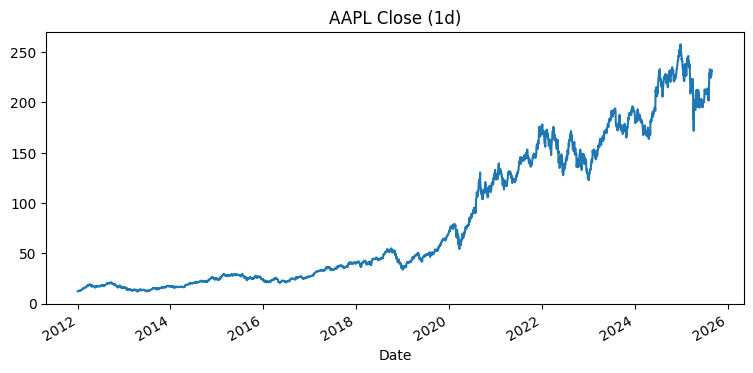

In [5]:
# === PLOTTING ===
# Kurzer visueller Check: Sieht der Kursverlauf plausibel aus?
df["close"].plot(title=f"{TICKER} Close ({INTERVAL})", figsize=(9,4))
plt.show()
plt.close()

In [6]:
# === SPEICHERN ===
# Die bereinigten Rohdaten werden jetzt eingefroren (gespeichert)
csv_path = RAW_CSV
df.to_csv(csv_path, float_format="%.8f")
print("CSV gespeichert unter:", csv_path)

CSV gespeichert unter: ../data/AAPL_1d_2012-01-01_2025-09-01.csv


In [7]:
# === METADATEN & PROFILING ===
# Wir erstellen einen Fingerabdruck (Hash) der Datei, um Veränderungen zu erkennen
def _sha256_file(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

# Zeitzonen-Info auslesen
tz_info = getattr(df.index, "tz", None)
tz_name = str(tz_info) if tz_info is not None else "naive"

# Das Manifest speichert, WAS wir geladen haben
manifest = {
    "ticker": TICKER, "interval": INTERVAL, "start": START, "end": END,
    "rows": int(len(df)),
    "first_ts": str(df.index.min()),
    "last_ts": str(df.index.max()),
    "sha256": _sha256_file(csv_path),
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "tz": tz_name,
    "source": "yfinance"
}
with open("../data/DATA_MANIFEST.json", "w") as f:
    json.dump(manifest, f, indent=2)

# Das Profiling speichert statistische Kennzahlen der Rohdaten
profiling = {
    "n": int(len(df)),
    "na_any": int(df.isna().any().any()),
    "close_min": float(df["close"].min()),
    "close_max": float(df["close"].max()),
    "logret_1d_mean": float(np.log(df["close"]).diff().dropna().mean()), # Durchschn. Log-Return
    "logret_1d_std": float(np.log(df["close"]).diff().dropna().std()),   # Volatilität
    "dup_timestamps": dup_count,
    "volume_zero_share": float((df["volume"]==0).mean())
}
with open("../data/profiling.json", "w") as f:
    json.dump(profiling, f, indent=2)

print("Manifest & Profiling geschrieben.")

Manifest & Profiling geschrieben.


In [8]:
# === SETUP FÜR LABELING ===
import os, sys, json, yaml
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = os.path.abspath("..")
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

# Config laden (für Feature-Parameter)
with open(os.path.join(ROOT, "config.json"), "r") as f:
    C = json.load(f)

TICKER   = C["ticker"]
START    = C["start"]
END      = C["end"]
INTERVAL = C["interval"]
FEATURESET = C.get("featureset", "v2")

# Parameter für Labeling
HORIZON   = int(C.get("horizon", 5))    # Vorhersagehorizont
LOOKBACK  = int(C.get("lookback", 60))  # Input-Fenster
EPS_MODE  = str(C.get("epsilon_mode", "abs"))
EPSILON   = float(C.get("epsilon", 0.0005)) # Schwellwert für "Up"/"Down"

# Pfad zur Datei von Block 1
raw_csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"

In [9]:
# === DATEN WIEDER LADEN ===
from finance_lstm import read_prices
# read_prices ist eine Hilfsfunktion, die das Laden und Parsen übernimmt
df_raw = read_prices(raw_csv_path)
# Sicherheitscheck: Preise müssen positiv sein
assert (df_raw["close"] > 0).all()

In [10]:
# === FEATURE ENGINEERING (Die "Intelligenz" des Modells) ===

# Hilfsfunktion für RSI (Relative Strength Index)
def _rsi(close: pd.Series, n=14):
    r = close.diff().fillna(0.0)
    up  = r.clip(lower=0.0); dn = (-r).clip(lower=0.0)
    roll_up = up.rolling(n, min_periods=n).mean()
    roll_dn = dn.rolling(n, min_periods=n).mean()
    rs  = roll_up / (roll_dn + 1e-12)
    return 100.0 - (100.0 / (1.0 + rs))

# Hilfsfunktion für MACD (Moving Average Convergence Divergence)
def _macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = close.ewm(span=fast, adjust=False, min_periods=fast).mean()
    ema_slow = close.ewm(span=slow, adjust=False, min_periods=slow).mean()
    macd = ema_fast - ema_slow
    macd_sig = macd.ewm(span=signal, adjust=False, min_periods=signal).mean()
    return macd, macd_sig, macd - macd_sig

# Hauptfunktion zum Erstellen aller Features
def build_features_v2(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    # 1. Log-Returns (die wichtigste Basisgröße)
    out["logret_1d"] = np.log(out["close"]).diff()
    out["logret_3d"] = out["logret_1d"].rolling(3,  min_periods=3).sum()
    out["logret_5d"] = out["logret_1d"].rolling(5,  min_periods=5).sum()
    
    # 2. Volatilität (Rolling Std Dev)
    out["realized_vol_10"] = out["logret_1d"].rolling(10, min_periods=10).std()
    
    # 3. Bollinger Bands Position
    sma20 = out["close"].rolling(20, min_periods=20).mean()
    std20 = out["close"].rolling(20, min_periods=20).std()
    out["bb_pos"] = (out["close"] - sma20) / (2.0*std20 + 1e-12)
    
    # 4. RSI
    out["rsi_14"] = _rsi(out["close"], 14)
    
    # 5. MACD
    macd, macd_sig, macd_diff = _macd(out["close"])
    out["macd"] = macd; out["macd_sig"] = macd_sig; out["macd_diff"] = macd_diff
    
    # 6. Volumen-Indikatoren (Z-Score des Log-Volumens)
    out["log_vol"] = np.log(out["volume"].replace(0, np.nan))
    roll_med = out["log_vol"].rolling(20, min_periods=20).median()
    roll_mad = out["log_vol"].rolling(20, min_periods=20).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True
    )
    # Clippen, um Ausreißer zu begrenzen
    out["vol_z_20"] = ((out["log_vol"] - roll_med) / (roll_mad + 1e-12)).clip(-10, 10)
    
    # 7. Trendstärke (SMA Diff)
    out["sma_diff"] = (out["close"].rolling(10, min_periods=10).mean() /
                       (out["close"].rolling(20, min_periods=20).mean() + 1e-12) - 1.0)
    return out

# Features anwenden
df_feat = build_features_v2(df_raw)

In [11]:
# === LABELING (Die Zielvariable für das Training) ===

# Wir wollen vorhersagen: Steigt der Preis in H Tagen?
# Dazu berechnen wir den "Forward Log Return"
fut = np.log(df_feat["close"]).shift(-HORIZON) # Preis in der Zukunft
cur = np.log(df_feat["close"])                 # Preis heute
fwd_logret = fut - cur

# Split-Indizes definieren (Train/Val/Test), um Data Leakage beim Thresholding zu vermeiden
n_total = len(df_feat)
n_train = int(n_total * 0.70)
n_val   = int(n_total * 0.15)
train_idx = slice(0, n_train)

# Threshold (Epsilon) bestimmen
if EPS_MODE == "quantile":
    # Dynamisch: Top X% der Returns gelten als "Up"
    q = EPSILON if 0 < EPSILON < 1 else 0.6
    eps_val = float(fwd_logret.iloc[train_idx].quantile(q))
    eps_mode_used = f"q{q:.2f}"
else:
    # Statisch: Fester Wert (z.B. 0.0005)
    eps_val = float(EPSILON)
    eps_mode_used = "abs"

# Target Label setzen: 1 (Kaufen/Up) wenn Return > Epsilon, sonst 0 (Warten/Down)
df_feat["target"] = (fwd_logret > eps_val).astype("int8")

# Optionales Zusatzlabel: Volatilitäts-bereinigt
z = fwd_logret / (df_feat["realized_vol_10"] + 1e-12)
df_feat["target_z"] = (z > 0.4).astype("int8")

# NaN-Zeilen (durch Rolling Features) entfernen
df_clean = df_feat.dropna().sort_index()

In [12]:
# === PROFILING UPDATE ===
# Wir speichern, wie viele Datenpunkte nach dem Feature Engineering noch übrig sind
prof_path = Path("../data/profiling.json")
try:
    profiling = json.load(open(prof_path, "r")) if prof_path.exists() else {}
except Exception:
    profiling = {}
profiling["n_after_dropna_features"] = int(len(df_clean))
with open(prof_path, "w") as f:
    json.dump(profiling, f, indent=2)

In [13]:
# === FEATURE DOKUMENTATION ===
# Wir speichern eine Liste der Features und ihre Beschreibung in einer YAML-Datei
features_list = [
    "logret_1d","logret_3d","logret_5d",
    "realized_vol_10","bb_pos","rsi_14",
    "macd","macd_sig","macd_diff",
    "vol_z_20","sma_diff",
]

# Dokumentation für jedes Feature
feature_docs = {
    "logret_1d": "Log-Return t→t+1 (1 Tag).",
    "logret_3d": "Summe Log-Returns über 3 Tage (rolling, mp=3).",
    "logret_5d": "Summe Log-Returns über 5 Tage (rolling, mp=5).",
    "realized_vol_10": "Realisiert. Std der 1d-Logreturns über 10 Tage.",
    "bb_pos": "Position relativ zu Bollinger-Bändern (SMA20±2*Std).",
    "rsi_14": "Relative Strength Index (14).",
    "macd": "EMA12-EMA26.",
    "macd_sig": "MACD Signal (EMA9 von MACD).",
    "macd_diff": "MACD minus Signal.",
    "vol_z_20": "Z-Score der Log-Volumen (Median/MAD über 20, clipped ±10).",
    "sma_diff": "SMA10/SMA20 - 1 (Trendverhältnis)."
}

feature_meta = {
    "name": f"features_{FEATURESET}",
    "features": features_list,
    "feature_docs": feature_docs,
    "label": {"horizon": HORIZON, "epsilon": eps_val, "mode": eps_mode_used},
    "note": "Nur rückwärtsgerichtete Rolling/EMA; keine Future-Leaks."
}
with open(f"../data/features_{FEATURESET}.yml", "w") as f:
    yaml.safe_dump(feature_meta, f, sort_keys=False)

In [14]:
# === TRAININGSDATEN EXPORTIEREN ===
# Wir speichern verschiedene Varianten der Trainingsdaten mit unterschiedlichen Thresholds (Epsilon)
# Das hilft uns, später zu testen, wie sensitiv das Modell auf die Labeling-Logik reagiert
eps_sweep = [eps_val] if EPS_MODE == "quantile" else sorted(set([eps_val, 0.001, 0.002]))

out_paths = []
for eps_out in eps_sweep:
    if EPS_MODE == "quantile":
        eps_tag = f"{eps_mode_used}{str(eps_val).replace('.','p')}"
        target_series = (fwd_logret > eps_val).astype("int8")
    else:
        eps_tag = f"abs{str(eps_out).replace('.','p')}"
        target_series = (fwd_logret > eps_out).astype("int8")

    # DataFrame kopieren und neues Target setzen
    df_out = df_feat.copy()
    df_out["target"] = target_series
    # WICHTIG: Erneut dropna, falls durch das Shiften des Targets neue NaNs am Ende entstanden sind
    df_out = df_out.dropna().sort_index()

    # Als CSV speichern
    train_csv_out = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}_{eps_tag}.csv"
    df_out.to_csv(train_csv_out, float_format="%.8f")
    out_paths.append(train_csv_out)
    print("Train-CSV:", train_csv_out, "| pos_rate:", round(df_out["target"].mean(),3), "| n:", len(df_out))

Train-CSV: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p0005.csv | pos_rate: 0.509 | n: 3402
Train-CSV: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p001.csv | pos_rate: 0.496 | n: 3402
Train-CSV: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p002.csv | pos_rate: 0.462 | n: 3402


In [15]:
# === ZUSAMMENFASSUNG ===
# Kurzer Report über die erzeugten Labels (Balance zwischen 0 und 1)
vc = df_clean["target"].value_counts().sort_index()
targets_summary = {
    "horizon": HORIZON, "epsilon": float(eps_val), "mode": eps_mode_used,
    "n": int(len(df_clean)),
    "class_counts": {int(k): int(v) for k, v in vc.items()},
    "pos_rate": float(vc.get(1,0)/vc.sum()) if vc.sum() else None,
    "exports": out_paths
}
with open("../data/targets_summary.json", "w") as f:
    json.dump(targets_summary, f, indent=2)

print("targets_summary:", targets_summary)
print(df_clean[["close","logret_1d","target","target_z"]].head())

targets_summary: {'horizon': 1, 'epsilon': 0.0005, 'mode': 'abs', 'n': 3402, 'class_counts': {0: 1669, 1: 1733}, 'pos_rate': 0.5094062316284539, 'exports': ['../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p0005.csv', '../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p001.csv', '../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p002.csv']}
                close  logret_1d  target  target_z
Date                                              
2012-02-21  15.440892   0.025037       0         0
2012-02-22  15.386603  -0.003522       1         0
2012-02-23  15.487074   0.006509       1         1
2012-02-24  15.667620   0.011590       1         1
2012-02-27  15.768089   0.006392       1         1


In [16]:
# === ÜBERGABE AN NÄCHSTEN SCHRITT ===
# Wir speichern, welche Datei für das Training verwendet werden soll
label_run = {
    "train_csv": out_paths[0],  # Wir nehmen standardmäßig die erste (Baseline)
    "features_yaml": f"../data/features_{FEATURESET}.yml",
    "label": {"horizon": HORIZON, "epsilon": float(eps_val), "mode": eps_mode_used},
}
with open("../data/LABEL_RUN.json", "w") as f:
    json.dump(label_run, f, indent=2)